<a href="https://colab.research.google.com/github/AllisonXiong/Content-Analysis/blob/main/Final_Project_Zhihan_Xiong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import sklearn.cluster

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

# comp-linguistics
import spacy
import nltk

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
# import jsonlines
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [361]:
import warnings
warnings.filterwarnings('ignore')

# 0 Read in dataset

In [ ]:
!pip install jsonlines

In [ ]:
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# import jsonlines
# take a look at the jsonl file...
i = 1
l = []
with open("drive/MyDrive/aylien_covid_news_data.jsonl", "r+", encoding="utf8") as f:
    for item in jsonlines.Reader(f):
        if i > 3:
            break
        l.append(item)
        i += 1

In [7]:
l[0].keys()

dict_keys(['author', 'body', 'categories', 'characters_count', 'entities', 'hashtags', 'id', 'keywords', 'language', 'links', 'media', 'paragraphs_count', 'published_at', 'sentences_count', 'sentiment', 'social_shares_count', 'source', 'summary', 'title', 'words_count'])

In [ ]:
l[0]

In [6]:
# read in jsonl file, transfer to dataframe
news = []
with open("drive/MyDrive/aylien_covid_news_data.jsonl", "r+", encoding="utf8") as f:
    for item in jsonlines.Reader(f):

        results = {}
        
        results['author'] = item['author']['name']
        results['title'] = item['title']
        results['body'] = item['body']
        results['hashtags'] = item['hashtags']
        results['id'] = item['id']
        results['language'] = item['language']
        results['url'] = item['links']['permalink']
        results['para_count'] = item['paragraphs_count']
        results['sent_count'] = item['sentences_count']
        results['word_count'] = item['words_count']
        results['date'] = item['published_at']
        results['sentiment'] = item['sentiment']
        results['source'] = item['source']['domain']
        results['country'] = item['source']['locations']
        results['country2'] = item['source']['scopes']
        results['body'] = item['body']
        
        news.append(results)

In [7]:
newsdf = pd.DataFrame(news)

In [8]:
newsdf.shape

(1673353, 15)

In [9]:
# get country of each news article
def find_country(ls):
    if len(ls) < 1:
        return 'None'
    else:
        return ls[0]['country']
newsdf['nation'] = newsdf['country'].apply(find_country)

In [ ]:
newsdf['nation'].value_counts()

In [11]:
df = newsdf[newsdf['nation']=='US']

In [12]:
df.shape

(435849, 16)

In [15]:
df['time'] = newsdf['date'].apply(lambda x: x[:10])
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,author,title,body,hashtags,id,language,url,para_count,sent_count,word_count,date,sentiment,source,country,country2,nation,time
0,Gavin Evans,British Prime Minister Boris Johnson Hospitali...,"On Sunday, British Prime Minister Boris Johnso...","[#PrimeMinisterOfTheUnitedKingdom, #BorisJohns...",74199025,en,https://www.complex.com/life/2020/04/boris-joh...,7,12,218,2020-04-05 23:59:42+00:00,"{'body': {'polarity': 'positive', 'score': 0.9...",complex.com,"[{'city': 'New York', 'country': 'US', 'state'...","[{'city': None, 'country': None, 'level': 'int...",US,2020-04-05
15,Daniel Politi,Bronx Zoo Tiger Is First of Its Kind to Test P...,"Nadia, a four-year-old female Malayan tiger at...","[#Coronavirus, #BronxZoo, #Virus, #Zoo, #Wildl...",74198970,en,https://slate.com/news-and-politics/2020/04/br...,15,15,339,2020-04-05 23:58:40+00:00,"{'body': {'polarity': 'neutral', 'score': 0.44...",slate.com,"[{'city': None, 'country': 'US', 'state': None}]","[{'city': None, 'country': 'US', 'level': 'nat...",US,2020-04-05
18,,Why John Dickerson wrote about acknowledging e...,Amid the confusion and anxiety of coronavirus ...,"[#Coronavirus, #Anxiety, #Virus, #TheAtlantic,...",74198957,en,http://feeds.cbsnews.com/~r/CBSNewsMain/~3/puk...,9,20,454,2020-04-05 23:57:57+00:00,"{'body': {'polarity': 'negative', 'score': 0.8...",cbsnews.com,"[{'city': None, 'country': 'US', 'state': None}]","[{'city': None, 'country': None, 'level': 'int...",US,2020-04-05
21,Mary Margaret Olohan,‘I Felt A Real Pain In My Heart For My Country...,"Police arrested David Benham on Saturday, sayi...","[#Abortion, #AbortionClinic, #Twitter, #Charlo...",74198940,en,https://dailycaller.com/2020/04/05/coronavirus...,49,81,1522,2020-04-05 23:57:29+00:00,"{'body': {'polarity': 'positive', 'score': 0.8...",dailycaller.com,"[{'city': None, 'country': 'US', 'state': None}]","[{'city': None, 'country': 'US', 'level': 'nat...",US,2020-04-05
27,Associated Press,"Couples in Quarantine: Stress, Anxiety, Fear o...",With all the havoc it's wreaking across the gl...,"[#Earth, #Coronavirus]",74198787,en,https://www.usnews.com/news/us/articles/2020-0...,1,1,23,2020-04-05 23:55:57+00:00,"{'body': {'polarity': 'positive', 'score': 0.6...",usnews.com,"[{'city': 'Washington', 'country': 'US', 'stat...","[{'city': None, 'country': 'US', 'level': 'nat...",US,2020-04-05


In [16]:
df['time'] = pd.to_datetime(df['time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df.describe()

,id,para_count,sent_count,word_count
count,4.358490e+05,435849.000000,435849.000000,435849.000000
mean,1.572923e+09,21.829684,25.104598,561.418622
std,1.468366e+09,49.801516,27.257586,563.484369
min,4.391327e+07,1.000000,1.000000,7.000000
25%,7.278749e+07,5.000000,10.000000,230.000000
50%,3.000311e+09,12.000000,18.000000,429.000000
75%,3.009579e+09,22.000000,33.000000,741.000000
max,3.020746e+09,5059.000000,1297.000000,23880.000000


In [35]:
df[df.word_count==7].body

802130    Sponsored Content by MassMutual               ...
Name: body, dtype: object

In [12]:
# filter out articles that are too short
df.drop(df[df.word_count < 100].index, inplace=True)

In [44]:
df.describe()

,id,para_count,sent_count,word_count
count,3.730220e+05,373022.000000,373022.000000,373022.000000
mean,1.577535e+09,25.126826,28.909013,646.871675
std,1.468298e+09,53.084188,27.701197,565.901750
min,4.391327e+07,1.000000,1.000000,100.000000
25%,7.283246e+07,8.000000,13.000000,315.000000
50%,3.000341e+09,14.000000,21.000000,497.000000
75%,3.009772e+09,25.000000,36.000000,811.000000
max,3.020746e+09,5059.000000,1297.000000,23880.000000


In [52]:
max(df.time)

Timestamp('2020-07-31 00:00:00')

In [20]:
newsdf.to_csv('newsdf.csv')

In [21]:
df.to_csv('usCovidNews.csv')

In [15]:
df = pd.read_csv('drive/MyDrive/usCovidNews.csv')

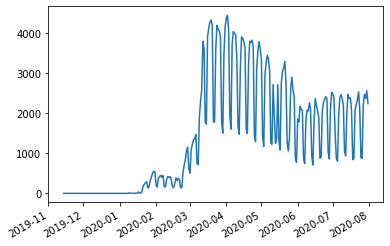

In [17]:
df['time'] = pd.to_datetime(df['time'])
df.time.value_counts().plot()

In [ ]:
# Tokenize the news article content, and normalize the tokens
df['tokenized_text'] = df['body'].apply(lambda x: lucem_illud.word_tokenize(x))


In [ ]:
df['normalized_text'] = df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))


Sampled 10% due to the time / computational resource concern.

The report before the outbreak in the U.S. is quite limited. Thus I manually added all the articles before that time to the sample.

In [18]:
early = df[df.time < '2020-01-19']

In [15]:
dfs = df.sample(37302)

In [16]:
dfs.to_csv('usCovidNewsShort.csv')

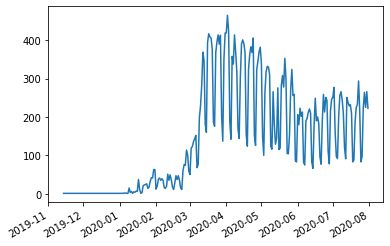

In [26]:
dfs.time.value_counts().plot()

In [22]:
dfs.drop(dfs[dfs.time < '2020-01-19'].index, inplace=True)

In [23]:
dfs = dfs.append(early)

In [24]:
dfs.shape

(37398, 19)

# 1 Computational Linguistics

In [3]:
dfs = pd.read_csv('drive/MyDrive/usCovidNewsShort.csv')

In [28]:
dfs['tokenized_text'] = dfs['body'].apply(lambda x: lucem_illud.word_tokenize(x))


In [29]:
# add the lemmatized form of the word
dfs['normalized_text'] = dfs['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))


In [30]:
dfs['normalized_tokens_count'] = dfs['normalized_text'].apply(lambda x: len(x))


In [32]:
dfs = dfs.reset_index(drop=True)

In [29]:
dfs['month'] = dfs.time.apply(lambda x: x.month)

In [7]:
dfss = dfs.sample(3000)

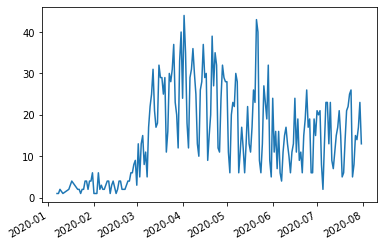

In [8]:
dfss.time.value_counts().plot()

In [10]:
dfss = dfss.reset_index(drop=True)

##### Aticle POS (x)

In [12]:
# A critical feature is a word's role in the sentence, or its part of speech (POS)
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [14]:
nlp = spacy.load("en")

In [ ]:
dfss['normalized_tokens_POS'] = [spacy_pos(t) for t in dfss['body']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the nltk.ConditionalFreqDist() function wants them. We can now construct another conditional frequency distribution.

In [ ]:
ncfdist_WordtoPOS = nltk.ConditionalFreqDist(dfss['normalized_tokens_POS'].sum())
list(ncfdist_WordtoPOS.items())[:10]

This gives the frequency of each word as each part of speech...which can be uninformative and boring. What we want is the converse; the frequency of each part of speech for each word.

In [ ]:
ncfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in dfs['normalized_tokens_POS'].sum())


In [ ]:
# identify and collect all of the superlative adjectives
ncfdist_POStoWord['JJ']

In [ ]:
# look at the most common nouns
ncfdist_POStoWord['NN'].most_common(5)

In [ ]:
# plot the base form verbs against their number of occurrences
ncfdist_POStoWord['VB'].plot()

We can even create a WORD CLOUD or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

In [ ]:
# import wordcloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(dfss['normalized_text'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covidnews_word_cloud.pdf", format = 'pdf')

##### Title POS tags
Do that again for the news title...

In [15]:
# a new column with the part of speech as a short initialism and the word in a tuple
dfss['normalized_tokens_POS_title'] = [spacy_pos(t) for t in dfss['title']]

In [18]:
# take a look of the first words (ordered on frequency)
ncfdist_WordtoPOS_title = nltk.ConditionalFreqDist(dfss['normalized_tokens_POS_title'].sum())
list(ncfdist_WordtoPOS_title.items())[:10]

[('watch', FreqDist({'NNP': 1, 'VB': 34})),
 ('live',
  FreqDist({'JJ': 15, 'NN': 1, 'NNP': 16, 'RB': 1, 'VB': 5, 'VBP': 2})),
 (':', FreqDist({':': 620})),
 ('president', FreqDist({'NN': 6, 'NNP': 15})),
 ('trump',
  FreqDist({'JJ': 13, 'NN': 45, 'NNP': 132, 'RB': 1, 'VB': 17, 'VBP': 5})),
 ('holds', FreqDist({'VBZ': 9})),
 ('a', FreqDist({'DT': 445, 'NNP': 1})),
 ('press', FreqDist({'NN': 5, 'NNP': 1})),
 ('conference', FreqDist({'JJ': 1, 'NN': 9, 'NNP': 2})),
 ('media', FreqDist({'NN': 1, 'NNP': 1, 'NNS': 8}))]

In [19]:
ncfdist_POStoWord_title = nltk.ConditionalFreqDist((p, w) for w, p in dfss['normalized_tokens_POS_title'].sum())


In [21]:
ncfdist_POStoWord_title['NN'].most_common(10)

[('home', 82),
 ('virus', 81),
 ('pandemic', 80),
 ('health', 54),
 ('state', 51),
 ('death', 50),
 ('%', 49),
 ('trump', 45),
 ('season', 42),
 ('crisis', 41)]

In [22]:
ncfdist_POStoWord_title['JJ'].most_common(10)

[('new', 143),
 ('positive', 46),
 ('first', 40),
 ('social', 38),
 ('black', 32),
 ('pandemic', 32),
 ('small', 28),
 ('next', 27),
 ('-', 27),
 ('global', 26)]

In [23]:
ncfdist_POStoWord_title['VB'].most_common(10)

[('be', 114),
 ('get', 54),
 ('reopen', 36),
 ('watch', 34),
 ('have', 33),
 ('stay', 32),
 ('help', 31),
 ('go', 28),
 ('do', 27),
 ('trump', 17)]

#### Word Clouds

In [7]:
dfs['tokenized_title'] = dfs['title'].apply(lambda x: lucem_illud.word_tokenize(x))

In [8]:
dfs['normalized_title'] = dfs['tokenized_title'].apply(lambda x: lucem_illud.normalizeTokens(x))


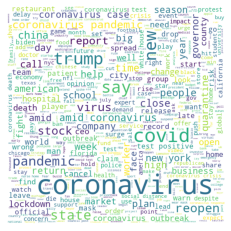

In [12]:
import wordcloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(dfss['normalized_title'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covidnewstitle_word_cloud.pdf", format = 'pdf')

1
2
3
4
5
6


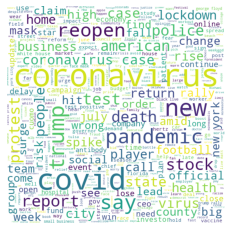

In [38]:
# plot and save word clouds for each month
for i in range(7):
  print(i+1)
  wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(dfss[dfss.month==(i+1)]['normalized_title'].sum()))
  plt.imshow(wc)
  plt.axis("off")
  plt.savefig("covidnewstitle_word_cloud{}.pdf".format(str(i+1)), format = 'pdf')

#### Hashtags

In [ ]:
dfss.hashtags[0].strip('[]\'').split('\', \'')

In [219]:
dfss['']

"['#Wuhan', '#China', '#SevereAcuteRespiratorySyndrome', '#PublicHealth', '#HongKong', '#SARS', '#Fever', '#CDC', '#CentersForDiseaseControlAndPrevention', '#Epidemiology', '#Quarantine', '#Virus', '#Taiwan', '#Civet', '#Pneumonia', '#MiddleEastRespiratorySyndrome', '#Pathogen', '#Asia', '#PublicTransport', '#ViralPneumonia', '#SouthChinaAA', '#Stall', '#Bazaar', '#Seafood', '#Chital', '#Venom', '#SurgicalMask', '#Epidemic', '#MassHysteria', '#Reservoir', '#Guangdong', '#WorldHealthOrganization', '#CommunistPartyOfChina', '#Asphyxia', '#Influenza', '#InfluenzaAVirusSubtypeH5N1', '#Adenoviridae', '#NucleicAcid', '#SARSCoronavirus', '#NewYear', '#TheWho', '#IncidentManagement', '#RespiratoryDisease', '#Zoonosis', '#BloombergLP', '#MERS', '#Anxiety', '#ChineseNewYear', '#Beijing', '#Pharmacy', '#CarrieLam', '#HighspeedRail', '#Thermoregulation', '#Washington']['#China', '#Coronavirus', '#HongKong', '#SevereAcuteRespiratorySyndrome', '#ViralPneumonia', '#Epidemiology', '#HongKongInternatio

In [249]:
dfss['hashtag'] = dfss['hashtags'].apply(lambda x: x.strip('[]\'').split('\', \'') if isinstance(x, str) else x)

5
6
7


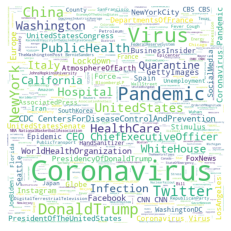

In [253]:
import wordcloud
for i in range(3):
  print(i+5)
  wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(dfss[dfss.month==(i+1)]['hashtag'].sum()))
  plt.imshow(wc)
  plt.axis("off")
  plt.savefig("covidnewstag_word_cloud{}.pdf".format(str(i+5)), format = 'pdf')

#### Another POS tagging technique..

In [48]:
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [ ]:
dfss['sentences'] = dfss['body'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])


In [ ]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [ ]:
dfss['POS_sents'] = dfss['sentences'].apply(lambda x: tag_sents_pos(x))

#### Another word counting method

In [26]:
all_normed = dfs.normalized_text.tolist()

In [27]:
wordLst = [x for j in all_normed for x in j]

In [45]:
len(wordLst)

12187581

In [47]:
dfs.word_count.sum()

24433210

In [50]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

In [51]:
countedWords = wordCounter(wordLst)
countedWords[:10]

,word,count
0,break,6494
1,news,24327
2,alert,1463
3,special,4192
4,report,33328
5,story,10984
6,matt,5648
7,deliver,5594
8,weekday,558
9,morning,6014


In [52]:
# sort and plot our counts to investigate the shape of our word frequency distribution.
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

,word,count
38,say,167394
58,coronavirus,87639
28,people,74099
50,new,64334
51,state,57865
...,...,...
506,group,14557
33,april,14550
612,end,14539
406,center,14482


In [ ]:
countsDict = {}
for word in dfs['body'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts_body = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts_body[:20]

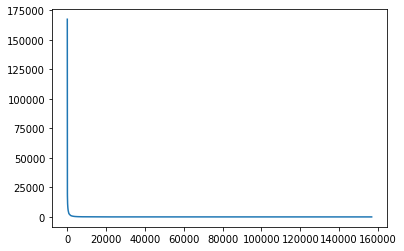

In [53]:
#Creating a figure and axis lets us do things like change the scaling or add a title
# likelihood of a word occurring is inversely proportional to its rank. 
# This effect is called Zipf's Law, and suggests that the most frequent word will 
# occur approximately twice as often as the second most frequent word
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

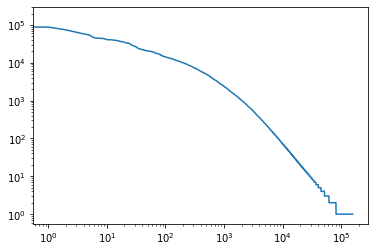

In [54]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [62]:
nText = nltk.Text(dfs.tokenized_text[0])

nIndex = nltk.text.ConcordanceIndex(nText) 
nIndex.print_concordance('say')

No matches


In [65]:
nText.common_contexts(['news'])

breaking_alerts the_and nbc_and nbc_count


##### Collocations (did not work)

find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (n-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length n).

In [ ]:
nBigrams = nltk.collocations.BigramCollocationFinder.from_words(wordLst)
print("There are {} bigrams in the finder".format(nBigrams.N))

In [18]:
def bigramScoring(count, wordsTuple, total):
    return count

print(nBigrams.nbest(bigramScoring, 10))

[(',', ' '), ("'", ','), (' ', "'"), ('e', "'"), ('t', "'"), ('y', "'"), ("'", 's'), ("'", 'c'), ('r', 'e'), ('e', 'r')]


In [19]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
nBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]

[((',', ' '), 6607859.341022171),
 ((' ', "'"), 3820143.768120459),
 (("'", ','), 3771927.243323198),
 (('y', "'"), 257351.42497117695),
 (('o', 'n'), 195151.19441727287),
 (('i', "'"), 166902.3524400718),
 (('e', ','), 165448.66599149222),
 (("'", 'e'), 148735.90713474262),
 (('c', 'o'), 134475.6934033225),
 (('i', 'n'), 131953.99084260676),
 (('a', "'"), 130581.18526996751),
 (('v', 'e'), 116162.79386238474),
 (('s', 't'), 108787.19079788924),
 (('o', "'"), 107078.18954054397),
 (('o', 'r'), 100307.3765589426),
 (('r', ','), 99423.35036795492),
 (('r', 'e'), 97563.36742958937),
 (('t', ','), 96658.99791418813),
 (('a', 'l'), 96582.82485465953),
 (('n', 't'), 95650.1641259533),
 (('o', ','), 91433.60662945845),
 (('e', 'r'), 87562.79555474118),
 (('v', 'i'), 86124.66341582488),
 (('a', 'n'), 83739.45049890642),
 (('t', 'i'), 82640.37924229492),
 (('a', 'e'), 77892.5612386421),
 (('c', 'h'), 77190.71715290105),
 (('d', 'e'), 75870.16681153789),
 (('s', ','), 75615.70325574517),
 (('u',

In [20]:
import gensim

In [21]:
bigram = gensim.models.Phrases(dfss['normalized_text'])

In [22]:
texts = [bigram[line] for line in dfss['normalized_text']]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


# 2 Topic Modeling

In [32]:
# convert the documents into word count vectors
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsVects = ngCountVectorizer.fit_transform(dfss['body'])
print(newsVects.shape)

(3000, 48003)


In [33]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsVects = ngCountVectorizer.fit_transform(dfs['body'])
print(newsVects.shape)

(37398, 155969)


In [35]:
# lookup the indices of different words using the Vectorizer
ngCountVectorizer.vocabulary_.get('trump')

141964

In [36]:
# tdidf vectorization
#initialize
newsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsVects)
#train
newsTF = newsTFTransformer.transform(newsVects)
print(newsTF.shape)

(37398, 155969)


In [37]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsTF.data))[:20]

[('get', 0.02456286065477091),
 ('breaking', 0.018549877315673317),
 ('news', 0.036680378922260455),
 ('alerts', 0.03803200891798223),
 ('and', 0.024138966227430676),
 ('special', 0.12937112385777016),
 ('reports', 0.040644283120737985),
 ('the', 0.020630268675035944),
 ('stories', 0.01065810794630424),
 ('that', 0.05229624960703478),
 ('matter', 0.03835385856438542),
 ('delivered', 0.02629310725609588),
 ('weekday', 0.04826458813414483),
 ('mornings', 0.02267484355185922),
 ('an', 0.05148304631015866),
 ('amazon', 0.02632216834331935),
 ('warehouse', 0.23411581661650005),
 ('in', 0.2709618297336377),
 ('minnesota', 0.019948041665779594),
 ('was', 0.029525712082464)]

Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or both). 

To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [41]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsTFVects = ngTFVectorizer.fit_transform(dfs['body'])

In [42]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['news', 'special', 'reports', 'stories', 'matter', 'delivered', 'amazon', 'site', 'cases', 'according'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

##### K means clustering
Didn't work well

In [43]:
numClusters = len(set(dfs['month']))
numClusters

9

In [44]:
dfs['month'].value_counts()

4     9419
3     8091
5     6771
7     6128
6     5338
2     1175
1      470
11       4
12       2
Name: month, dtype: int64

In [47]:
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(newsTFVects)

KMeans(n_clusters=9)

In [48]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(dfs['month'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(dfs['month'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(dfs['month'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(dfs['month'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_gamma_deviance', 'mean_pinball_loss', 'me

In [49]:
dfs['kmeans_predictions'] = km.labels_

In [50]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 like
 just
 home
 year
 police
 news
 video
 family
 says
 day


Cluster 1:
 company
 business
 employees
 workers
 businesses
 million
 companies
 work
 customers
 stores


Cluster 2:
 biden
 trump
 sanders
 election
 voters
 democratic
 campaign
 voting
 mail
 president


Cluster 3:
 state
 cases
 county
 health
 deaths
 officials
 city
 cuomo
 order
 york


Cluster 4:
 students
 school
 schools
 learning
 education
 university
 student
 online
 college
 parents


Cluster 5:
 season
 players
 league
 games
 game
 team
 sports
 nba
 nfl
 play


Cluster 6:
 trump
 president
 house
 white
 donald
 administration
 fauci
 news
 states
 campaign


Cluster 7:
 china
 health
 virus
 patients
 cases
 medical
 disease
 hospital
 chinese
 care


Cluster 8:
 market
 stock
 quarter
 billion
 oil
 company
 year
 stocks
 investors
 shares




In [51]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsTFVects.toarray())
reduced_data = pca.transform(newsTFVects.toarray())

In [52]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [56]:
colordict = {
'11': 'gainsboro',
'12': 'gray',
'1': 'green',
'2': 'blue',
'3': 'red',
'4': 'orange',
'5': 'purple',
'6': 'olive',
'7': 'cyan',
    }
colors = [colordict[str(c)] for c in dfs['month']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('11', 'gainsboro'), ('12', 'gray'), ('1', 'green'), ('2', 'blue'), ('3', 'red'), ('4', 'orange'), ('5', 'purple'), ('6', 'olive'), ('7', 'cyan')])


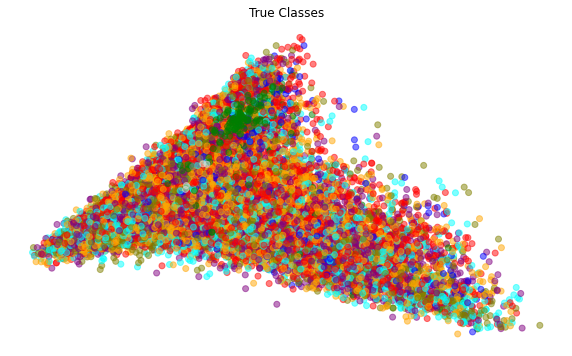

In [57]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

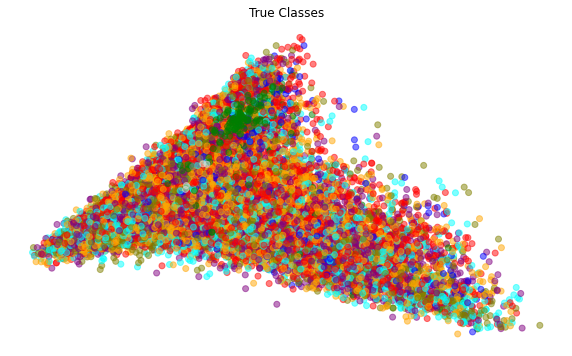

In [58]:
# plot the data using the true labels as the colors of our data points.
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [60]:
months=['11','12','1','2','3','4','5','6','7']

In [61]:
colors_p = [colordict[months[l]] for l in km.labels_]

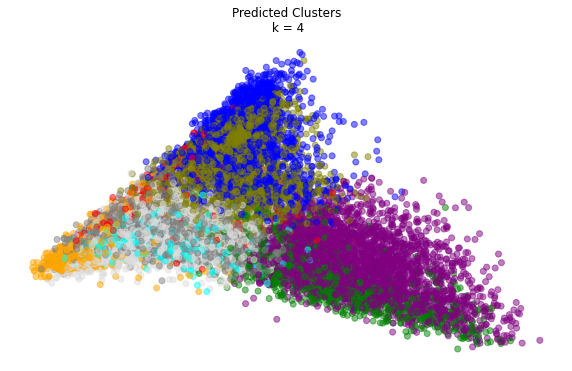

In [62]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [63]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


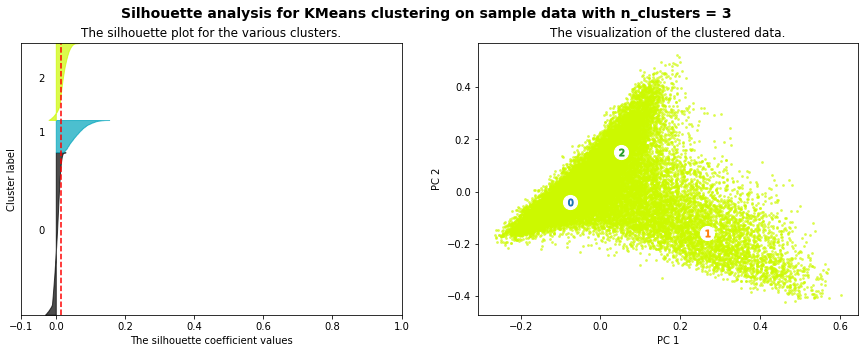

For n_clusters = 3, The average silhouette_score is : 0.014


In [64]:
X = newsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


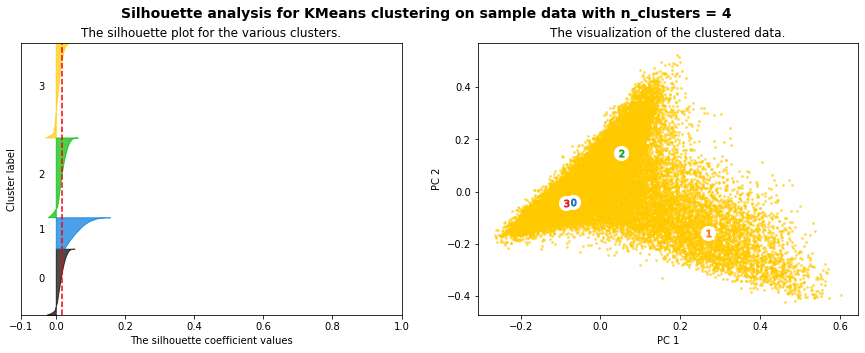

For n_clusters = 4, The average silhouette_score is : 0.018


In [65]:
plotSilhouette(4, X)

In [ ]:
import stylecloud
from IPython.display import Image
import os

filename = 'wordcloud_tweet_covid.png'

c_str = ''
for i in covid_df['clean_text']:
    c_str = c_str + '\n' + i.upper()
    
stylecloud.gen_stylecloud(text=c_str, icon_name='fab fa-twitter', output_name=filename)
Image(filename=filename)

#### LDA topic modeling & visualization

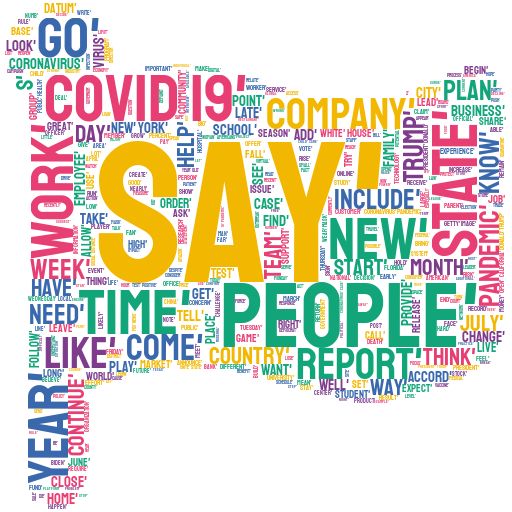

In [78]:
import stylecloud
from IPython.display import Image
import os

filename = 'wordcloud_news_covid.png'

c_str = ''
for i in dfss[dfss.month==7]['normalized_text']:
    c_str = c_str + '\n' + i.upper()
    
stylecloud.gen_stylecloud(text=c_str, output_name=filename)
Image(filename=filename)

In [ ]:
!pip install stylecloud

In [81]:
########################
# Find Topics 
########################
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
# get raw words and give them frequency
def find_topics(texts, max_features=2000, ntopics=6, nshow=20):
    '''
    '''
    ## max features limits the number of 3000. most common words
    tf_vectorizer = CountVectorizer(max_features=max_features, 
                                    stop_words='english')
    tf_text = tf_vectorizer.fit_transform(texts)

    # Perform LDA on vectors
    model = LatentDirichletAllocation(n_components=ntopics, max_iter=10, 
                                      learning_method='online', n_jobs=-1)
    lda = model.fit(tf_text)

    vocab = tf_vectorizer.get_feature_names()
    topic_words = {}
    for topic, comp in enumerate(lda.components_):
        word_idx = np.argsort(comp)[::-1][:nshow]
        topic_words[topic] = [vocab[i] for i in word_idx]

    # Data visualization
    data = pyLDAvis.sklearn.prepare(lda, tf_text, tf_vectorizer)

    return topic_words, data

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
!pip install pyLDAvis

In [184]:
topics_covid, data_covid = find_topics(dfss['body'], ntopics=4)

In [185]:
pyLDAvis.display(data_covid)

In [191]:
for topic, words in topics_covid.items():
    print('Topic: %d' % topic)
    print('  %s' % ', '.join(words))

Topic: 0
  trump, president, said, house, coronavirus, state, biden, white, states, police, news, campaign, donald, new, government, senate, administration, democratic, americans, washington
Topic: 1
  com, https, covid, students, school, 19, new, amazon, www, online, pandemic, work, help, schools, 2020, company, need, coronavirus, tax, time
Topic: 2
  said, coronavirus, health, people, new, covid, 19, cases, virus, state, public, city, officials, disease, 000, patients, testing, medical, spread, masks
Topic: 3
  said, business, year, million, company, coronavirus, new, 2020, market, pandemic, march, companies, billion, businesses, week, according, 000, economic, april, 19
Topic: 4
  said, people, like, just, time, going, don, home, ve, know, think, make, work, new, way, right, really, says, day, want


In [190]:
topics_covid, data_covid = find_topics(dfss['body'], ntopics=5)
pyLDAvis.display(data_covid)

In [187]:
topics_covid, data_covid = find_topics(dfss['body'], ntopics=6)
pyLDAvis.display(data_covid)

##### Genism

To use the texts with gensim we need to create a corpua object

In [129]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

dfs['reduced_tokens'] = dfs['normalized_tokens'].apply(lambda x: dropMissing(x, ngTFVectorizer.vocabulary_.keys()))

In [135]:
dictionary = gensim.corpora.Dictionary(dfs['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. =

In [137]:
corpus = [dictionary.doc2bow(text) for text in dfs['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [138]:
gensim.corpora.MmCorpus.serialize('news.mm', corpus)
newsmm = gensim.corpora.MmCorpus('news.mm')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
nlda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, alpha='auto', eta='auto')


In [194]:
n1Bow = dictionary.doc2bow(dfs['reduced_tokens'][0])
n1lda = nlda[n1Bow]
print("The topics of the text: {}".format(dfs['title'][0]))
print("are: {}".format(n1lda))

The topics of the text: Amazon warehouse in Minnesota had more than 80 COVID-19 cases
are: [(0, 0.6539922), (1, 0.09517792), (4, 0.24925584)]


We can now see which topics our model predicts press releases load on and make this into a dataFrame for later analysis.

In [203]:
ldaDF = pd.DataFrame({
        'name' : dfs['title'],
        'month': dfs['month'],
        'topics' : [nlda[dictionary.doc2bow(l)] for l in dfs['reduced_tokens']]
    })

In [204]:
# to make each topic its own column:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(nlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(nlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,month,topics,topic_0,topic_1,topic_2,topic_3,topic_4
1,These housing markets are in danger of a coron...,4,"[(1, 0.44403026), (2, 0.034391597), (3, 0.0405...",0.000000,0.444030,0.034392,0.040524,0.480828
101,Disney+ paid subscribers jump past 50 million,4,"[(1, 0.23175022), (4, 0.75936866)]",0.000000,0.231750,0.000000,0.000000,0.759369
201,From crown to scrubs: A British beauty queen s...,5,"[(0, 0.40335345), (1, 0.1971126), (2, 0.335499...",0.403353,0.197113,0.335499,0.000000,0.063532
301,"Air Canada to lay off over 5,100 employees due...",3,"[(0, 0.38134181), (4, 0.6139864)]",0.381342,0.000000,0.000000,0.000000,0.613986
401,Video games to try while social distancing,3,"[(1, 0.13706724), (2, 0.86060447)]",0.000000,0.137067,0.860604,0.000000,0.000000
...,...,...,...,...,...,...,...,...
36901,No one knows what the post-coronavirus reality...,3,"[(0, 0.56777865), (1, 0.089360915), (3, 0.2529...",0.567779,0.089361,0.000000,0.252981,0.089306
37001,COVID-19 patients shed coronavirus for 17 days...,5,"[(0, 0.99722064)]",0.997221,0.000000,0.000000,0.000000,0.000000
37101,A team of coding experts built an AI-powered p...,4,"[(0, 0.4791178), (2, 0.26964948), (4, 0.250486...",0.479118,0.000000,0.269649,0.000000,0.250487
37201,Broncos' Von Miller says he's recovered from C...,5,"[(0, 0.48565727), (1, 0.34499624), (2, 0.16672...",0.485657,0.344996,0.166725,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [199]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(5)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4
0,0.653978,0.095195,0.000000,0.000000,0.249253
1,0.000000,0.443981,0.034476,0.040543,0.480775
2,0.804240,0.000000,0.057701,0.000000,0.136693
3,0.000000,0.833078,0.000000,0.159716,0.000000
4,0.000000,0.000000,0.984805,0.013379,0.000000
5,0.000000,0.701736,0.192529,0.000000,0.104945
6,0.000000,0.648061,0.000000,0.350752,0.000000
7,0.000000,0.677047,0.000000,0.319760,0.000000
8,0.000000,0.190910,0.805072,0.000000,0.000000
9,0.741390,0.096475,0.161353,0.000000,0.000000


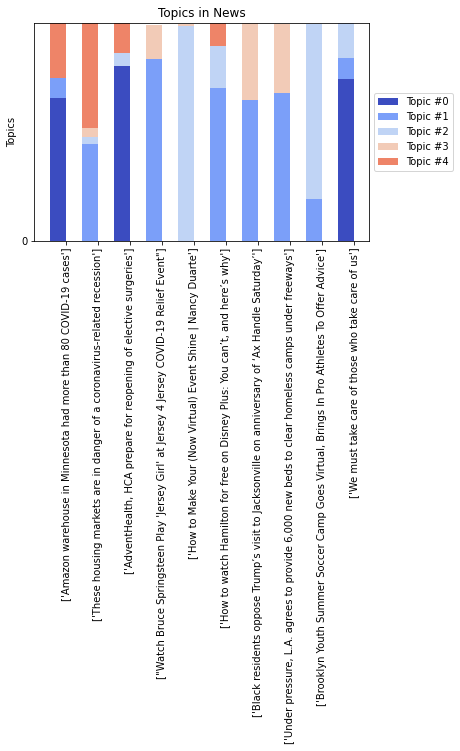

In [200]:
N = 10
ind = np.arange(N)
K = nlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in News')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


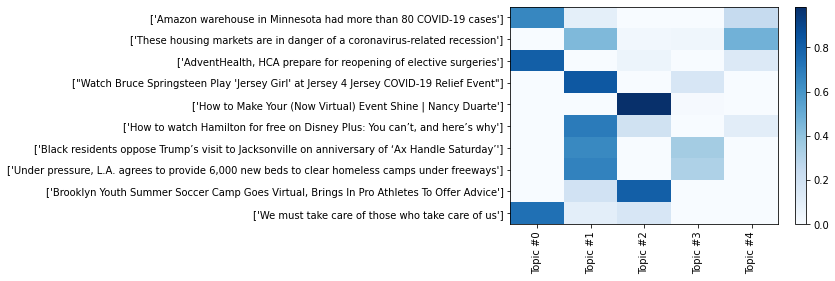

In [201]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic 1 we can do the following:

In [156]:
nlda.show_topic(1)

[('say', 0.036370877),
 ('health', 0.021502025),
 ('test', 0.019609213),
 ('state', 0.018899975),
 ('case', 0.018115966),
 ('virus', 0.015623564),
 ('report', 0.011320185),
 ('mask', 0.009191065),
 ('patient', 0.00902765),
 ('week', 0.008868079)]

In [202]:
topicsDict = {}
for topicNum in range(nlda.num_topics):
    topicWords = [w for w, p in nlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,say,say,work,trump,say
1,health,like,say,say,company
2,test,home,school,state,business
3,case,day,year,president,market
4,virus,city,like,house,year
5,patient,mask,need,biden,stock
6,report,live,team,vote,employee
7,state,know,student,white,week
8,hospital,come,season,week,month
9,disease,tell,think,campaign,price


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the  𝛼  and  𝜂  parameters of the model.  𝛼  controls the sparsity of document-topic loadings, and  𝜂  controls the sparsity of topic-word loadings.

In [ ]:
nlda1 = gensim.models.ldamodel.LdaModel(corpus=newsmm, id2word=dictionary, num_topics=4, eta = 0.00001)
nlda2 = gensim.models.ldamodel.LdaModel(corpus=newsmm, id2word=dictionary, num_topics=4, eta = 0.9)

<input>:6: DeprecationWarning: invalid escape sequence \e
<input>:6: DeprecationWarning: invalid escape sequence \e
<input>:7: DeprecationWarning: invalid escape sequence \e
<input>:6: DeprecationWarning: invalid escape sequence \e
<input>:7: DeprecationWarning: invalid escape sequence \e
<ipython-input-165-5861a5171e94>:6: DeprecationWarning: invalid escape sequence \e
  topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
<ipython-input-165-5861a5171e94>:7: DeprecationWarning: invalid escape sequence \e
  topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')


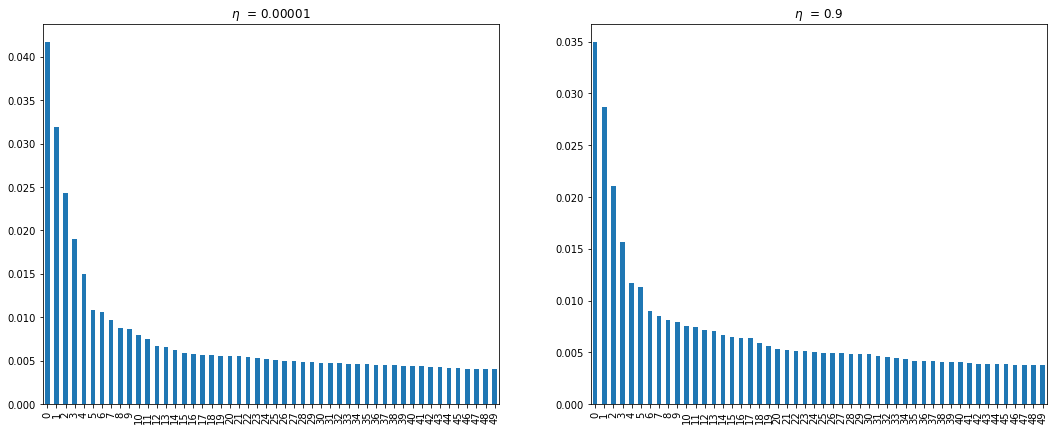

In [165]:
topic11_df = pd.DataFrame(nlda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(nlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

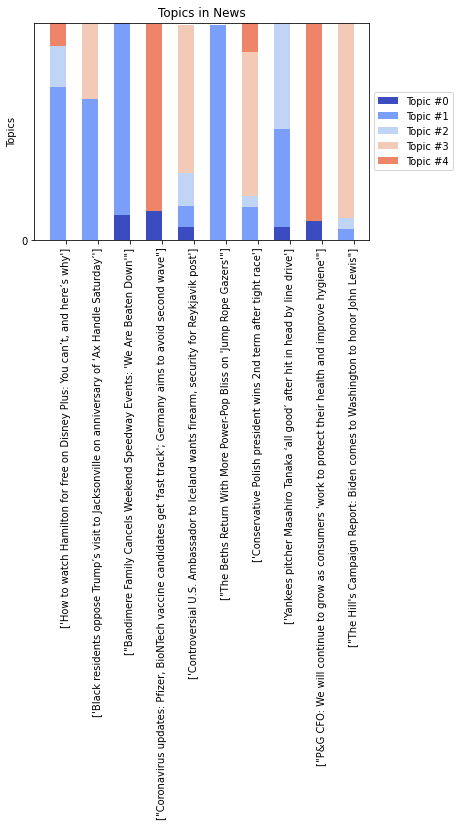

In [211]:
ldaDFV = ldaDF[ldaDF.month==7][:10][['topic_%d' %x for x in range(5)]]
ldaDFVisN = ldaDF[ldaDF.month==7][:10][['name']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()

N = 10
ind = np.arange(N)
K = nlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in News')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

# 3 Word Embedding

Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.



##### Word2Vec

In [417]:
# give all the sentences to the trainer
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
newsW2V = gensim.models.word2vec.Word2Vec(dfss['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (__getitem__) method:

In [260]:
newsW2V['coronavirus'][:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.20455766,  0.07411376, -0.07173865, -1.2570704 ,  0.46947107,
       -1.6100553 , -1.3268459 , -1.7184637 , -1.5189099 ,  1.5699141 ],
      dtype=float32)

In [261]:
# to translate from the matrix to words
newsW2V.wv.index2word[10]

'state'

In [262]:
newsW2V.most_similar('president')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('donald', 0.8499439358711243),
 ('obama', 0.8463741540908813),
 ('administration', 0.82088702917099),
 ('mcgahn', 0.8187119960784912),
 ('criticized', 0.7968308925628662),
 ('repeatedly', 0.790117621421814),
 ('pence', 0.7891537547111511),
 ('jinping', 0.78788161277771),
 ('vladimir', 0.7835221290588379),
 ('barack', 0.7816967964172363)]

In [263]:
newsW2V.most_similar('china')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('iran', 0.8796344995498657),
 ('europe', 0.8679379820823669),
 ('chinese', 0.8457427620887756),
 ('countries', 0.8382552862167358),
 ('italy', 0.8233997821807861),
 ('mainland', 0.8184064626693726),
 ('spain', 0.7986074686050415),
 ('germany', 0.7973326444625854),
 ('originated', 0.7882750034332275),
 ('russia', 0.7849206924438477)]

In [410]:
newsW2V.most_similar('mask')

[('masks', 0.9997705817222595),
 ('security', 0.9997552037239075),
 ('kemp', 0.9997490048408508),
 ('order', 0.9997406601905823),
 ('education', 0.9997178316116333),
 ('republican', 0.9997093081474304),
 ('issued', 0.9997053146362305),
 ('wearing', 0.9997047185897827),
 ('calls', 0.9997045397758484),
 ('asked', 0.9997036457061768)]

In [409]:
newsW2V.most_similar('coronavirus')

[('deaths', 0.9983316659927368),
 ('covid-19', 0.9982660412788391),
 ('confirmed', 0.9979325532913208),
 ('recorded', 0.9978163242340088),
 ('number', 0.9976156949996948),
 ('positive', 0.9976083636283875),
 ('reported', 0.9975776672363281),
 ('pandemic', 0.9975664019584656),
 ('amid', 0.9973146319389343),
 ('states', 0.9972952604293823)]

In [267]:
word = u'vaccine'  
ss = newsW2V.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to vaccine is: 
caused
epidemic
spreading
fears
contracting
effects
cure
spreads
novel
faring



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


In [418]:
newsW2V.most_similar(positive=['quarantine', 'u.s'], negative = ['china'])

[('residents', 0.8027457594871521),
 ('motel', 0.7816636562347412),
 ('facility', 0.7703073024749756),
 ('quarantined', 0.756013810634613),
 ('jail', 0.7500858306884766),
 ('employee', 0.7454820275306702),
 ('paramus', 0.7448415160179138),
 ('ordered', 0.740825891494751),
 ('remain', 0.7375540733337402),
 ('required', 0.7360852360725403)]

In [416]:
newsW2V.most_similar(positive=['trump', 'democratic'], negative = ['republican'])

[('president', 0.9987047910690308),
 ('televised', 0.9972078204154968),
 ('donald', 0.9913149476051331),
 ('listens', 0.9880125522613525),
 ('roundtable', 0.9870889782905579),
 ('walks', 0.9865183234214783),
 ('vice', 0.9860559701919556),
 ('house', 0.9854065775871277),
 ('escorted', 0.9851136207580566),
 ('topshot', 0.9838627576828003)]

In [278]:
newsW2V.save("newsWORD2Vec")

/usr/local/lib/python3.7/dist-packages/gensim/utils.py:589: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:590: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:591: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/

use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [279]:
numWords = 50
targetWords = newsW2V.wv.index2word[:numWords]

In [ ]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(newsW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [282]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)


In [283]:
reducedPCA_data = pcaWords.transform(wordsSubMatrix)

In [284]:
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

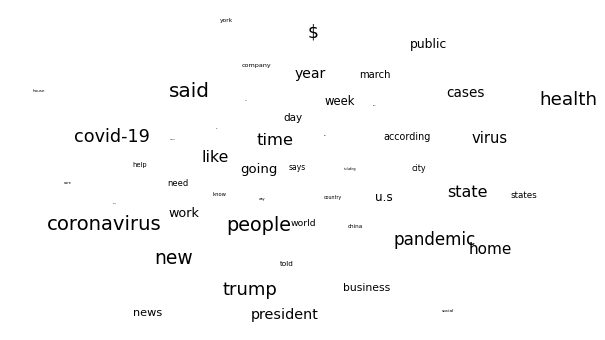

In [285]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

does the word embeddings change across time...??

In [ ]:
word = u'vaccine'  
ss = newsW2V.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [404]:
weLst=[]
words = ['china', 'chinese', 'wuhan', 'mask', 'coronavirus', 'covid', 'vaccine', 'trump', 'quarantine',  'republican']
for i in range(7):
  results = {}
  results['month'] = i + 1
  newsW2V = gensim.models.word2vec.Word2Vec(dfss[dfss.month==(i+1)]['normalized_sents'].sum(), sg=0)
  print(i + 1)
  for w in words:
     ss = newsW2V.similar_by_word(w,topn=10)
     results[w] = [i[0] for i in ss]

  weLst.append(results)
weDf = pd.DataFrame(weLst)

1
2
3
4
5
6
7


In [405]:
weDf

,month,china,chinese,wuhan,mask,coronavirus,virus,vaccine,trump,quarantine,republican
0,1,"[new, said, virus, health, chinese, impeachment, people, coronavirus, wuhan, flights]","[china, health, virus, new, people, wuhan, impeachment, said, confirmed, disease]","[people, health, new, china, chinese, said, virus, impeachment, including, coronavirus]","[tuesday, sunday, seafood, impeachment, trial, confirmed, prevention, china, wuhan, house]","[china, virus, said, people, new, including, wuhan, health, flights, chinese]","[china, health, said, people, chinese, coronavirus, new, confirmed, flights, wuhan]","[national, los, closed, roberts, identified, sunday, american, vote, foreign, health]","[new, people, health, virus, china, said, wuhan, coronavirus, officials, spread]","[new, confirmed, virus, china, chinese, wuhan, coronavirus, including, people, health]","[witnesses, vote, new, gop, state, respiratory, president, world, trump, said]"
1,2,"[said, virus, chinese, coronavirus, outbreak, people, health, told, $, new]","[china, said, health, virus, world, people, disease, told, coronavirus, quarantine]","[people, said, health, china, outbreak, coronavirus, chinese, $, virus, including]","[tuesday, china, week, film, told, outbreak, said, news, u.s, $]","[said, china, virus, including, people, chinese, officials, city, health, outbreak]","[china, said, coronavirus, city, spread, chinese, reported, health, people, outbreak]","[national, crew, cruise, language, trade, american, economic, general, closed, outside]","[said, officials, virus, health, china, people, president, spread, coronavirus, government]","[china, chinese, virus, said, coronavirus, new, world, city, officials, including]","[york, hundreds, state, traded, center, world, american, know, new, set]"
2,3,"[worldwide, infections, case, death, iran, toll, died, patients, total, diagnosed]","[taken, warned, shut, cdc, despite, potentially, limit, early, epidemic, inmates]","[growing, countries, far, affected, hit, related, infection, spreads, tests, spreading]","[instead, current, sales, helping, potential, major, group, operations, women, includes]","[covid-19, confirmed, deaths, positive, spread, outbreak, tested, virus, cases, disease]","[caused, novel, disease, number, causes, poop, epicenter, https://apnews.com/understandingtheout...","[given, potential, border, panic, treatment, limited, uncertainty, fear, age, ill]","[president, donald, vice, melania, joe, lady, pence, attacked, biden, brazilian]","[coming, self, possible, isolated, continue, ill, closing, additional, returning, isolation]","[election, political, comments, party, served, called, chief, office, committee, virtual]"
3,4,"[handling, continues, chinese, contain, worldwide, wuhan, emerged, combat, complications, surge]","[worldwide, handling, threat, iran, treated, participants, case, contain, deadly, efforts]","[complications, related, suspected, midst, diagnosed, continues, death, breakdown, toll, emerged]","[gloves, allowing, experience, sell, goods, internet, coffee, allows, champion, offer]","[covid-19, deaths, cases, amid, outbreak, pandemic, confirmed, reported, cumulative, march]","[tested, positive, spread, caused, number, disease, novel, hospitalized, patients, died]","[treat, massive, traditional, cure, exposed, causing, recovery, potential, guide, impacted]","[donald, president, vice, listens, belittled, house, white, barack, administration, pence]","[coming, suffering, crew, blood, determine, potentially, worst, inside, meaning, forced]","[democratic, presidential, tweet, repeatedly, john, speaking, tweeted, allies, adviser, talks]"
4,5,"[twitter, campaign, mike, america, obama, asked, american, tweet, golf, dr]","[party, law, community, helping, information, leaders, especially, network, major, given]","[noted, live, opening, case, led, party, include, higher, rates, demand]","[needed, cooper, continue, use, experience, power, digital, provide, network, able]","[covid-19, amid, deaths, re

In [296]:
weDf.china

0                 [new, said, health, virus, chinese, impeachment, people, coronavirus, wuhan, flights]
1                       [said, health, outbreak, chinese, virus, coronavirus, people, $, u.s, reported]
2                  [worldwide, died, infections, diagnosed, patients, case, deadly, iran, jumped, toll]
3    [continues, handling, wuhan, complications, cluster, toll, chinese, emerged, afternoon, suspected]
4                      [campaign, twitter, asked, ceo, statement, fact, american, obama, america, mike]
5                              [large, days, u.s, including, video, service, data, deal, future, ahead]
6                [party, numbers, despite, travel, added, recently, came, including, saying, following]
Name: china, dtype: object

In [295]:
pd.set_option('max_colwidth',100)

In [297]:
weDf.trump

0                    [health, new, people, virus, china, said, wuhan, officials, coronavirus, spread]
1          [said, health, officials, people, china, coronavirus, virus, government, president, world]
2                     [donald, president, vice, declare, melania, joe, lady, biden, pence, brazilian]
3    [donald, president, vice, belittled, listens, house, white, barack, administration, downplaying]
4                     [president, donald, vice, xi, administration, biden, barack, joe, obama, house]
5                   [vice, president, bolton, biden, campaign, john, obama, joe, win, administration]
6     [president, televised, walks, listens, vice, donald, escorted, topshot, imminently, roundtable]
Name: trump, dtype: object

In [298]:
weDf.coronavirus

0                     [china, virus, said, people, including, new, health, wuhan, flights, chinese]
1                       [said, china, virus, people, including, chinese, health, reported, $, week]
2            [covid-19, positive, confirmed, tested, spread, deaths, outbreak, cases, virus, novel]
3    [covid-19, deaths, outbreak, cases, amid, confirmed, pandemic, reported, cumulative, positive]
4            [covid-19, amid, deaths, response, latest, daily, novel, confirmed, delivered, brazil]
5           [covid-19, deaths, reported, confirmed, number, positive, amid, state, increase, virus]
6          [covid-19, deaths, confirmed, reported, recorded, state, number, positive, surge, spike]
Name: coronavirus, dtype: object

In [300]:
weDf['mask']

0    [tuesday, sunday, seafood, impeachment, trial, prevention, confirmed, china, wuhan, outbreak]
1                                 [tuesday, week, china, u.s, outbreak, news, $, told, film, said]
2            [event, potential, major, increased, women, sense, noted, specific, current, helping]
3                  [gloves, leave, ones, allowing, internet, ability, sell, offer, products, rest]
4         [needed, cooper, use, experience, digital, provide, despite, continued, ensure, network]
5                     [masks, face, continue, asked, room, rules, require, help, employees, women]
6            [masks, order, americans, kemp, calls, education, republican, decision, asked, power]
Name: mask, dtype: object

In [301]:
weDf.vaccine

0        [national, los, roberts, closed, identified, american, sunday, vote, foreign, health]
1            [national, crew, cruise, economic, american, health, new, trade, tuesday, closed]
2    [given, started, potential, increased, current, situation, limited, major, crew, foreign]
3             [rapidly, humans, sars, stop, massive, exposed, risks, appear, forced, epidemic]
4       [shows, project, information, actually, shut, change, instead, questions, story, site]
5                      [series, project, plan, fact, world, future, tax, financial, help, set]
6    [patients, phase, outbreak, disease, infection, testing, risk, related, potential, study]
Name: vaccine, dtype: object

In [302]:
weDf.quarantine

0           [new, confirmed, virus, china, chinese, coronavirus, wuhan, including, people, health]
1               [china, chinese, world, said, virus, coronavirus, city, health, people, including]
2    [coming, possible, facilities, self, close, doctor, potentially, ordered, returning, believe]
3                 [crew, coming, suffering, avoid, inside, blood, bars, reach, forced, activities]
4                   [close, comes, closed, hand, plans, person, expected, quickly, outside, allow]
5                       [including, days, report, start, march, higher, u.s, comes, world, recent]
6      [start, patients, infection, community, coming, research, began, potential, results, close]
Name: quarantine, dtype: object

In [406]:
weDf.republican

0                    [witnesses, vote, new, gop, state, respiratory, president, world, trump, said]
1                          [york, hundreds, state, traded, center, world, american, know, new, set]
2         [election, political, comments, party, served, called, chief, office, committee, virtual]
3    [democratic, presidential, tweet, repeatedly, john, speaking, tweeted, allies, adviser, talks]
4                       [ceo, democratic, wrote, friday, running, gop, called, night, party, asked]
5                      [called, running, added, set, race, said, center, based, democratic, taking]
6                      [called, democratic, ceo, political, race, sign, leaders, bill, gop, policy]
Name: republican, dtype: object

# 4 Classification

Timestamp('2020-03-13 00:00:00')

Previous analysis has revealed a shift of topics, thus, it may be possible to classify articles published in different periods of time based on their contextual features

In [346]:
# March 13 — Trump Declares COVID-19 a National Emergency
neDate = pd.to_datetime('2020-03-13')
dfss['category'] = [s < neDate for s in dfss['time']]


In [347]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(dfss, test_size=holdBackFraction)


In [348]:
print(len(train_data_df))
print(len(test_data_df))

2400
600


In [369]:
# modify the evaluation functions a bit...
def evaluateClassifier(clf, testDF, vect_name):
    predictions = clf.predict(np.stack(testDF[vect_name], axis=0))
    classes = []
    results = {
        'Error_Rate' : [],
        'AUC' : [],
        'Precision' : [],
        'Average_Precision' : [],
        'Recall' : [],
        }

    for cat in set(testDF['category']):
        preds = [True if (c == cat) else False for c in predictions]
        acts = [True if (c == cat) else False for c in testDF['category']]
        classes.append(cat)
        results['AUC'].append(sklearn.metrics.roc_auc_score(acts, preds))
        results['Average_Precision'].append(sklearn.metrics.average_precision_score(acts, preds))
        results['Precision'].append(sklearn.metrics.precision_score(acts, preds))
        results['Recall'].append(sklearn.metrics.recall_score(acts, preds))
        results['Error_Rate'].append(1 -  sklearn.metrics.accuracy_score(acts, preds))
    df = pd.DataFrame(results, index=classes)
    df.index.rename('Category', inplace=True)
    return df

def plotMultiROC(clf, testDF, vect_name):
    #By making the column names variables we can easily use this function on new data sets

    #Get the names of each of the possible classes and the probabiltiess
    classes = clf.classes_
    try:
        probs = clf.predict_proba(np.stack(testDF[vect_name], axis=0))
    except AttributeError:
        print("The {} classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.".format(type(clf)))
        return
    predictions = clf.predict(np.stack(testDF[vect_name], axis=0))

    #setup axis for plotting
    fig, ax = plt.subplots(figsize = (10,10))

    #We can return the AUC values, in case they are useful
    aucVals = []
    for classIndex, className in enumerate(classes):        #Setup binary classes
        truths = [1 if c == className else 0 for c in testDF['category']]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title('Receiver Operating Characteristics')
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()

#### logistic regression

In [349]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['body'])


In [350]:
TFVects.shape

(2400, 21760)

In [351]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [352]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


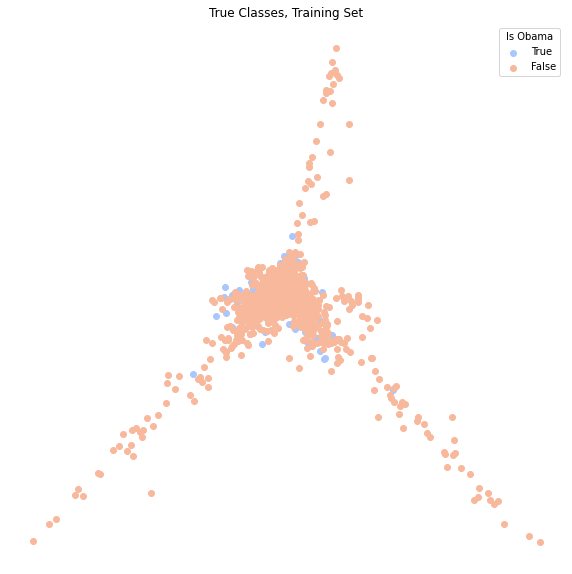

In [353]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot before march13
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot after
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

In [364]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])
# 0.90125

0.90125

In [365]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['body'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.895

In [371]:
dfss.category.value_counts()

False    2700
True      300
Name: category, dtype: int64

In [370]:
evaluateClassifier(logistic, test_data_df, 'pca_reduced_10')

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.105,0.5,0.895,0.895,1.0
True,0.105,0.5,0.000,0.105,0.0


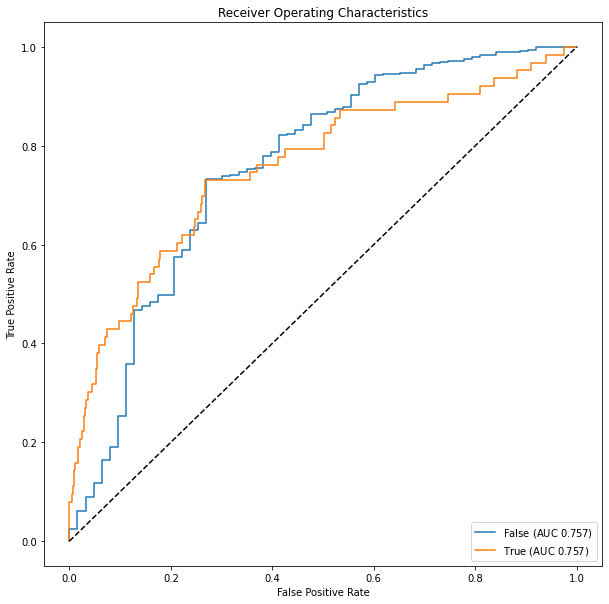

In [372]:
plotMultiROC(logistic, test_data_df, 'pca_reduced_10')

In [373]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.9041666666666667
Testing:
0.8966666666666666


In [374]:
evaluateClassifier(logistic, test_data_df, 'pca_reduced_40')

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.103333,0.507937,0.896494,0.896494,1.000000
True,0.103333,0.507937,1.000000,0.119206,0.015873


In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
 0.9058333333333334

Testing:
 0.8966666666666666

with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ( 𝑌𝑖 ) and the estimated values ( 𝑓(𝑥𝑖) ) and prunes all insignificant variables (i.e., word TF-IDF scores):

In [375]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9066666666666666


In [376]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8966666666666666


In [377]:
evaluateClassifier(logistic_l1, test_data_df, 'vect')

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.103333,0.507937,0.896494,0.896494,1.000000
True,0.103333,0.507937,1.000000,0.119206,0.015873


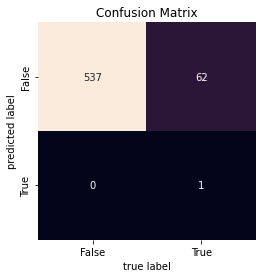

In [421]:
lucem_illud.plotConfusionMatrix(logistic_l1, test_data_df)

#### Decision Tree

In [379]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


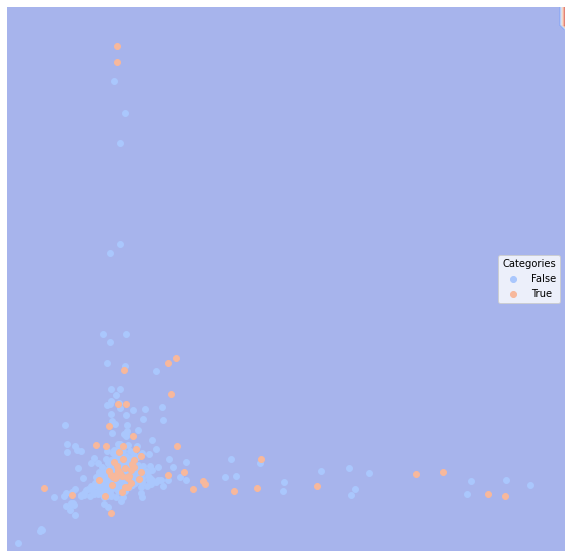

In [387]:
lucem_illud.plotregions(clf_tree, test_data_df)

In [382]:
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.07625,0.61956,0.923077,0.923047,0.998613
True,0.07625,0.61956,0.950000,0.303481,0.240506


In [384]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.8933333333333333

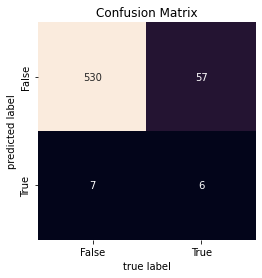

In [398]:
lucem_illud.plotConfusionMatrix(clf_tree, test_data_df)

#### RF

In [385]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [386]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

In [ ]:
lucem_illud.plotregions(bag, test_data_df)

In [ ]:
lucem_illud.evaluateClassifier(bag, test_data_df)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

#### KNN

In [389]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [390]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [391]:
#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.9016666666666666


In [392]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.098333,0.552762,0.905085,0.905028,0.994413
True,0.098333,0.552762,0.700000,0.171111,0.111111


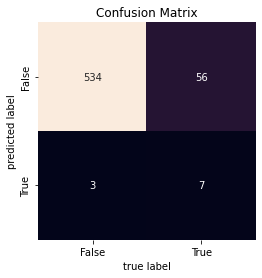

In [393]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

#### SVM

In [394]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

SVC(kernel='linear')

In [395]:
lucem_illud.evaluateClassifier(clf_svm, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.098333,0.552762,0.905085,0.905028,0.994413
True,0.098333,0.552762,0.700000,0.171111,0.111111


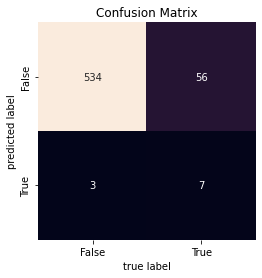

In [396]:
lucem_illud.plotConfusionMatrix(clf_svm, test_data_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


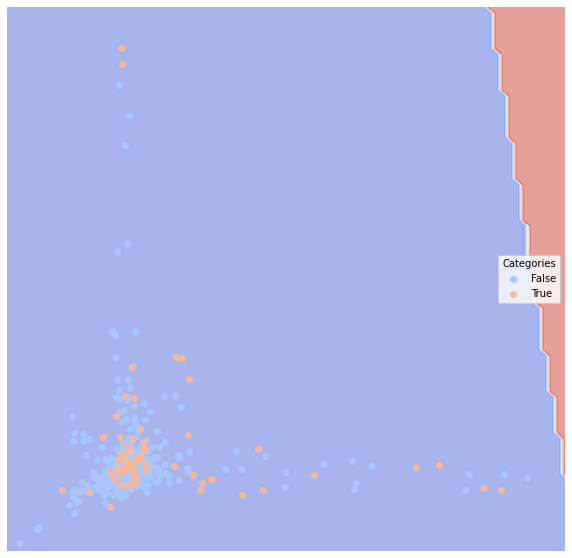

In [397]:
lucem_illud.plotregions(clf_svm, test_data_df)

#### neural network

In [399]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier()

In [400]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.093333,0.597588,0.913941,0.91373,0.988827
True,0.093333,0.597588,0.684211,0.22452,0.206349


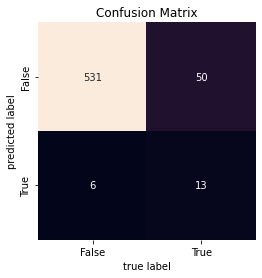

In [401]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


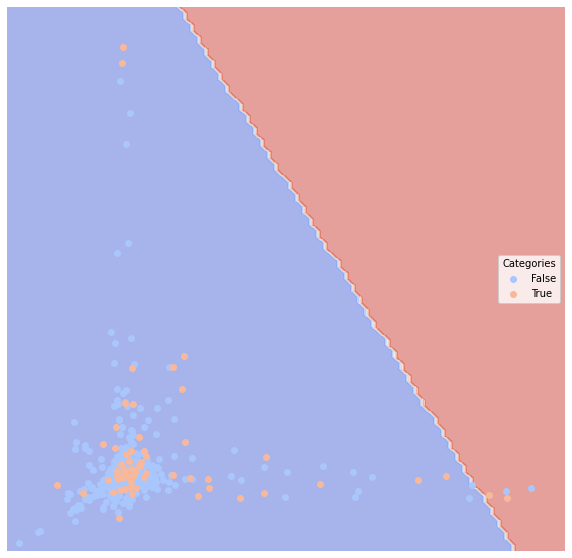

In [402]:
lucem_illud.plotregions(clf_nn, test_data_df)

# 5 Other attempts...
I also tried sentiment analysis

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

I referenced this [detailed BERT tutorial](https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671) for the sentiment analysis

In [ ]:

def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'body'
LABEL_COLUMN = 'sentiment'
view rawbertImdb_cmpltInputForm.py hosted with ❤ by GitHub

In [216]:

dfs.hashtags

0        ['#Amazon', '#Minnesota', '#ShakopeeMinnesota'...
1        ['#County', '#MyrtleBeachSouthCarolina', '#Las...
2        ['#Physician', '#Florida', '#ChariRiver', '#He...
3        ['#BruceSpringsteen', '#JerseyGirl', '#EStreet...
4        ['#Videotelephony', '#Protein–proteinInteracti...
                               ...                        
37393    ['#Pandemic', '#Virus', '#EbolaVirusDisease', ...
37394    ['#Virus', '#Washington', '#HospitalacquiredIn...
37395    ['#Virus', '#Nucleotide', '#AntiviralDrug', '#...
37396    ['#Coronavirus', '#Lille', '#RNA', '#RNA', '#F...
37397    ['#Kidney', '#Coronavirus', '#Utrecht', '#Rece...
Name: hashtags, Length: 37398, dtype: object

In [311]:
import ast
ast.literal_eval(dfs.sentiment[0])

{'body': {'polarity': 'negative', 'score': 0.96005},
 'title': {'polarity': 'neutral', 'score': 0.558311}}

In [315]:
dfs.dropna(subset=['sentiment'], inplace=True)

In [316]:
dfs['sentiments'] = dfs.sentiment.apply(lambda x: ast.literal_eval(x))

In [321]:
def get_score(dic):
  if dic is None:
    return 0
  if dic['polarity'] == 'positive':
    pola = 1
  elif dic['polarity'] == 'negative':
    pola = -1
  else:
    pola = 0
  return pola * dic['score']

In [322]:
dfs['sentiment_body'] = dfs.sentiments.apply(lambda x: get_score(x['body']) if len(x)>0 else 0)

In [323]:
dfs['sentiment_title'] = dfs.sentiments.apply(lambda x: get_score(x['title']) if len(x)>0 else 0)

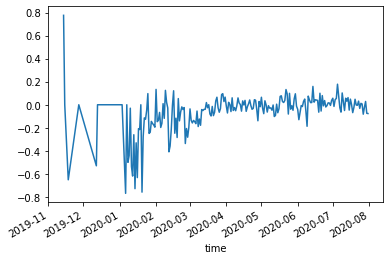

In [328]:
# average sentiment score for the content of news articles...
dfs.groupby(['time'])['sentiment_body'].mean().plot()

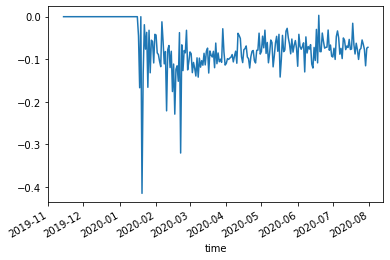

In [329]:
# average sentiment score for the title of news articles...
dfs.groupby(['time'])['sentiment_title'].mean().plot()